# 新しいネットワークを書いてみよう

ここでは、MNISTデータセットではなくCIFAR10という32x32サイズの小さなカラー画像に10クラスのいずれかのラベルがついたデータセットを用いて、いろいろなモデルを自分で書いて試行錯誤する流れを体験してみます。

| airplane | automobile | bird | cat | deer | dog | frog | horse | ship | truck |
|:--------:|:----------:|:----:|:---:|:----:|:---:|:----:|:-----:|:----:|:-----:|
| ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png) |

## モデルの定義

モデルは、`Chain`クラスを継承して定義します。ここでは、以前試した全結合層だけからなるネットワークではなく、畳込み層を持つネットワークを定義してみます。

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L

class MyModel(chainer.Chain):
    
    def __init__(self, n_out):
        super(MyModel, self).__init__(
            conv1=L.Convolution2D(None, 32, 3, 3, 1),
            conv2=L.Convolution2D(32, 64, 3, 3, 1),
            conv3=L.Convolution2D(64, 128, 3, 3, 1),
            fc4=L.Linear(None, 1000),
            fc5=L.Linear(1000, n_out)
        )
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

## 学習

では`Trainer`を用いて、CIFAR10データセットの画像を10クラスに分類するように訓練してみましょう。

In [2]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

batchsize = 64
gpu_id = 0
max_epoch = 20

# 1. Dataset
train, test = cifar.get_cifar10()

# 2. Iterator
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

# 3. Model
model = MyModel(10)
model = L.Classifier(model)
model.to_gpu(gpu_id)

# 4. Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

# 5. Updater
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# 6. Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='cifar10_result')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.55021     0.432964       1.3442                0.507265                  5.81079       
2           1.24361     0.552077       1.20383               0.57086                   11.0822       
3           1.09252     0.606274       1.15816               0.585689                  16.3019       
4           0.971236    0.653469       1.08333               0.61664                   21.4328       
5           0.858733    0.692935       1.05867               0.624801                  26.5601       
6           0.750933    0.732494       1.06612               0.627588                  31.7479       
7           0.636682    0.773207       1.12086               0.629976                  36.8354       
8           0.526144    0.814381       1.15784               0.628583                  42.0291       
9           0.417735    0.854          1.26199               0.628583               

学習が一通り終わりました。ロスと精度のプロットを見てみましょう。

ロス：
![](cifar10_result/loss.png)

精度：
![](cifar10_result/accuracy.png)

学習データでの精度は98%近くまで到達していますが、テストデータではロスはむしろIterationを進むごとに大きくなってしまっており、また精度も60%付近で頭打ちになってしまっています。モデルが学習データにオーバーフィッティングしていると思われます。

## 学習済みモデルを使った予測

テスト精度は60%程度でしたが、この学習済みモデルを使っていくつかのテスト画像を分類させてみましょう。

predicted_label: cat
answer: cat


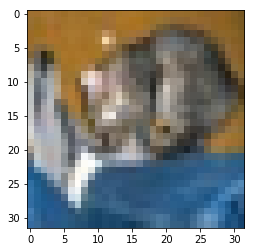

predicted_label: ship
answer: ship


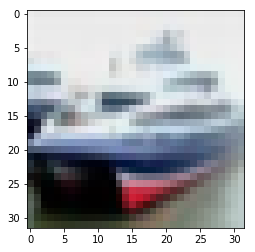

predicted_label: airplane
answer: ship


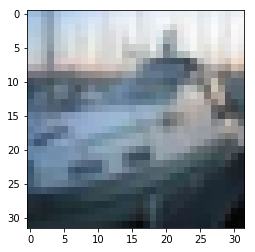

predicted_label: automobile
answer: airplane


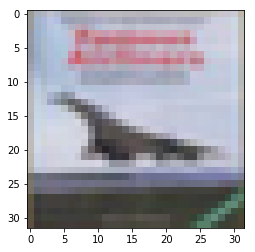

predicted_label: bird
answer: frog


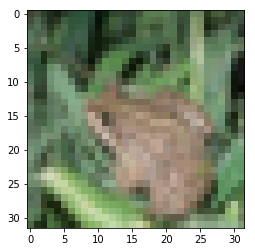

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(image_id):
    x, t = test[image_id]
    model.to_cpu()
    y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

predict(0)
predict(1)
predict(2)
predict(3)
predict(4)